# Python solutions of Lab 5 for IIVP

## Import Libraries

In [558]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
from skimage.util import random_noise
from scipy.signal import wiener

## 1 Removal of DC Component


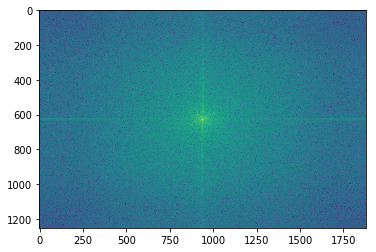

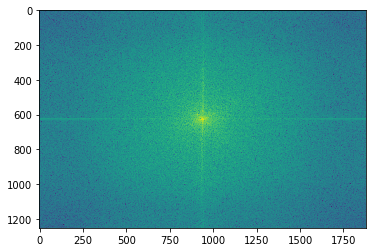

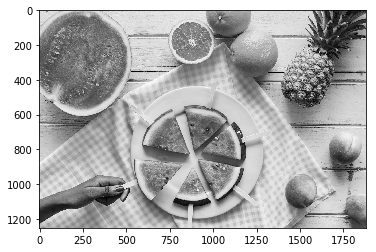

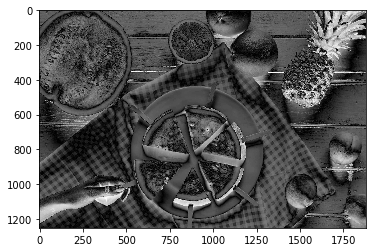

In [559]:
x = cv2.imread("redfruits.jpg", 0)
f1 = np.fft.fftshift(np.fft.fft2(x))

plt.imshow(np.log(np.abs(f1)))
plt.show()

n1, n2 = x.shape

f2 = np.copy(f1)
f2[int(n1/2) , int(n2/2)] = 0

plt.imshow(np.log(np.abs(f2)))
plt.show()

y = np.fft.ifft2(f2)

plt.imshow(np.abs(x), cmap = 'gray')
plt.show()

plt.imshow(np.abs(y), cmap = 'gray')
plt.show()

## 2 Periodic Noise Removal - Notch Filter

### Creation of periodic noise

In [560]:
def periodic_noise(f0, n1, n2):
    [t1, t2] = np.mgrid[0:n2, 0:n1]
    n = np.sin(2*np.pi*f0*((t1-1)/n2 + (t2-1) / n1))
    return n

### Display image and fft of original and noisy image 

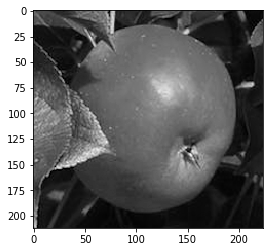

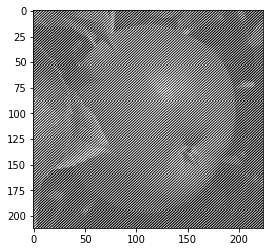

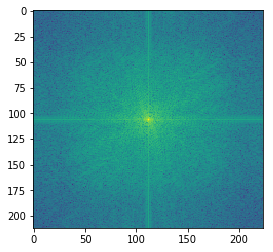

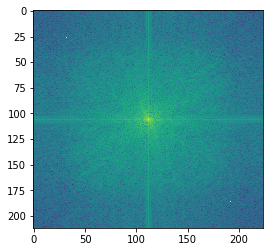

In [561]:
x = cv2.imread('apple.jpg', 0).astype(np.double)

plt.imshow(x, cmap= 'gray')
plt.show()

[n2, n1] = x.shape

m = 250

f0 = 80
n = m*periodic_noise(f0, n1, n2)

y = x+n

plt.imshow(y, cmap= 'gray')
plt.show()

fx = np.fft.fftshift(np.fft.fft2(x))
fy = np.fft.fftshift(np.fft.fft2(y))
fn = np.fft.fftshift(np.fft.fft2(n))

plt.imshow(np.log(np.abs(fx)))
plt.show()

plt.imshow(np.log(np.abs(fy)))
plt.show()

### Notch filter

In [562]:
def notchfilter(f0, n1, n2):
    [k1, k2] = np.mgrid[-np.round(n2/2):np.round(n2/2), -np.round(n1/2):np.round(n1/2)]
    d1 = np.sqrt((k1-f0)**2 + (k2-f0)**2)
    d2 = np.sqrt((k1+f0)**2 + (k2+f0)**2)
    d0 = 40
    h = ((d1 < d0) | (d2 < d0)).astype(int)
    return h

### Apply notch filter

C:\Users\Felix\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


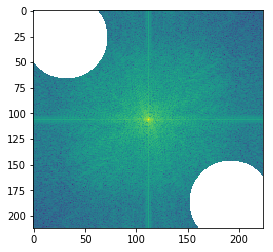

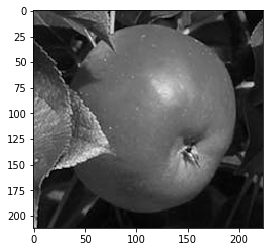

In [563]:
h1 = notchfilter(f0, n1, n2)
fz1 = fy * (1-h1)
z1 = np.fft.ifft2(fz1)

plt.imshow(np.log(np.abs(fz1)))
plt.show()

plt.imshow(np.abs(z1), cmap='gray')
plt.show()

   ### 3 Additive Noise Removal - Wiener Filter 

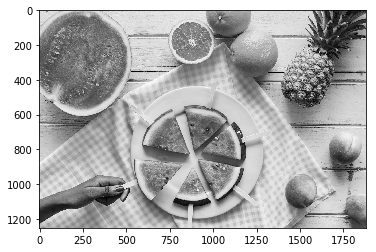

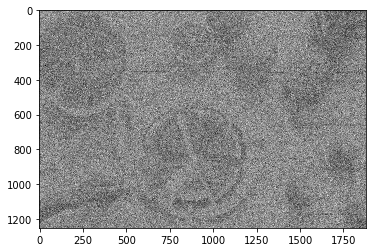

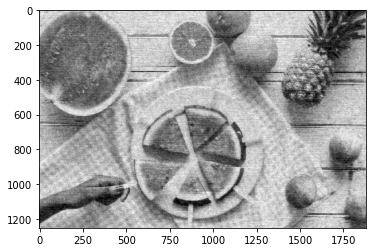

In [564]:
img = cv2.imread('redfruits.jpg', 0)
n1, n2 = img.shape

f = np.fft.fftshift(np.fft.fft2(img))
sf = np.abs(f)**2

nm = 130
n = nm * np.random.randn(n1,n2)

fn =  np.fft.fftshift(np.fft.fft2(n))
sn = np.abs(fn)**2

y = img + n

fy = np.fft.fftshift(np.fft.fft2(y))

# assume snr is known
snr = sn / sf
fest = fy / (1+snr)

xest = np.fft.ifft2(fest)

plt.imshow(img, cmap='gray')
plt.show()

plt.imshow(y, cmap='gray')
plt.show()

plt.imshow(np.abs(xest), cmap='gray')
plt.show()

## 4 Image degradation and restoration

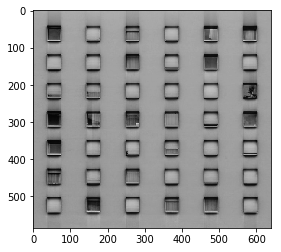

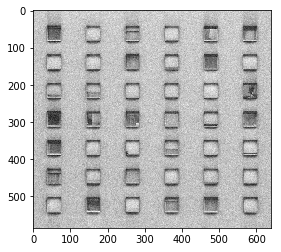

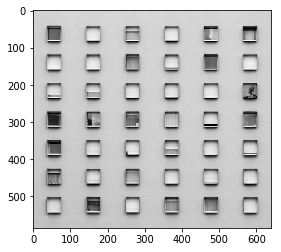

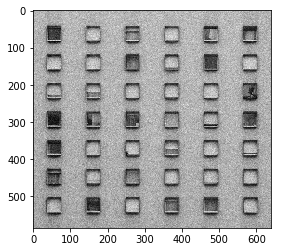

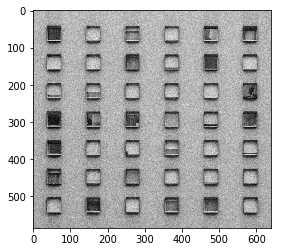

C:\Users\Felix\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:492: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()
C:\Users\Felix\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:375: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, complex) or
C:\Users\Felix\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:376: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, com

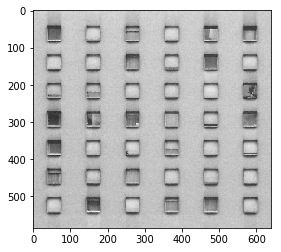

In [565]:
x = cv2.imread('win1.jpg', 0)
x = x.astype(np.double)

n2, n1 = x.shape


[k1, k2] = np.mgrid[0:n2, 0:n1]

[u,v] = np.mgrid[-n2/2:n2/2, -n1/2:n1/2]
u = 2*u/n2
v = 2*v/n1

F = np.fft.fft2(x)

a = 0.13
b = 0

#Blurring function.
H = np.sinc((u*a + v*b)) * np.exp(-1j*np.pi*(u*a + v*b))
G = F * H

# Motion Blurred Image.
g = np.fft.ifft2(G)
plt.imshow(np.abs(g), cmap= 'gray')
plt.show()

# Noisy AND Motion Blurred image.
xn = random_noise(np.abs(g).astype(np.uint8), 'gaussian', mean=0, var=0.002)
xn = xn.astype(np.double)
Fn = np.fft.fft2(xn)
plt.imshow(xn, cmap='gray')
plt.show()

# A basic way to assess the power spectrum of the noise, with the
# assumption the original image x and the motion blurred and noisy image xn
# are known. We conisder the pproximation of the noise is x-xn.
nn = x - xn
snn = abs(np.fft.fft2(nn)) ** 2
sxx = abs(np.fft.fft2(x)) ** 2

# 2D Wiener filter
dh = np.abs(H) ** 2 + snn / sxx
Hw = np.conj(H) / dh

# Wiener filtered motion blurred image
R1 = Hw * G
rx1 = np.abs(np.fft.ifft2(R1))
plt.imshow(rx1, cmap= 'gray')
plt.show()

# Wiener filtered motion blurred and noisy image
R2 = Hw * Fn
rx2 = np.abs(np.fft.ifft2(R2))
plt.imshow(rx2, cmap='gray')
plt.show()

# Application of an inverse filter to an image with additive noise and with motion blur
R3 = Fn / H
rx3 = np.abs(np.fft.ifft2(R3))
plt.imshow(rx3, cmap= 'gray')
plt.show()

# Scipy Wiener filter
r0 = wiener(np.abs(xn))
plt.imshow(r0, cmap='gray')
plt.show()